# This allows us to test TentaclePlanner with a simulated robot + our real PI controller

In [20]:
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython import display

from robot_core.hardware.simulated_diff_drive_robot import DiffDriveRobot
from robot_core.control.PI_controller import PIController
from robot_core.motion.tentacle_planner import TentaclePlanner


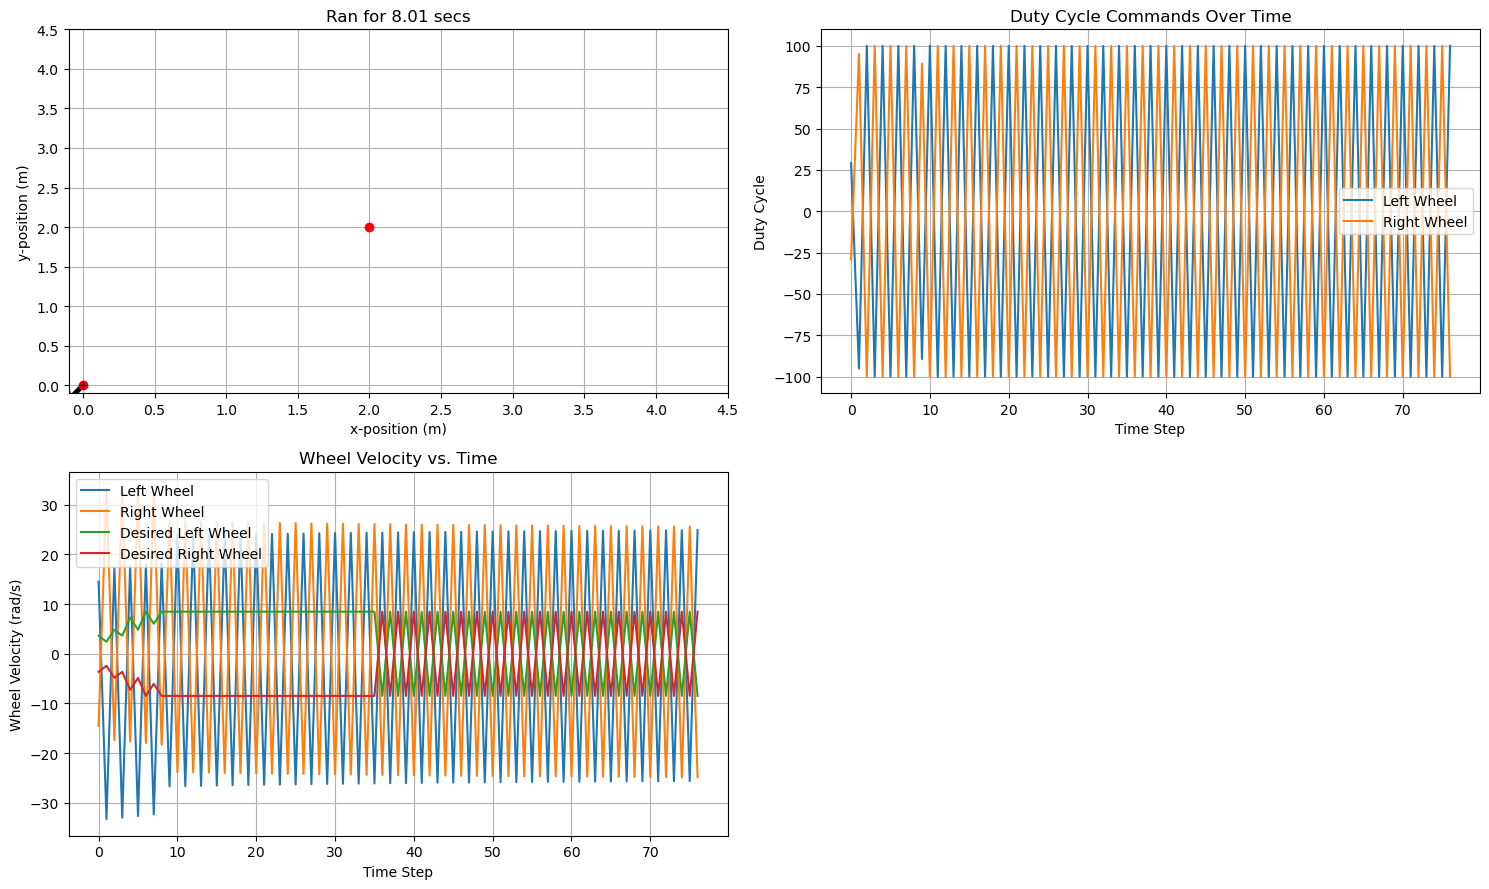

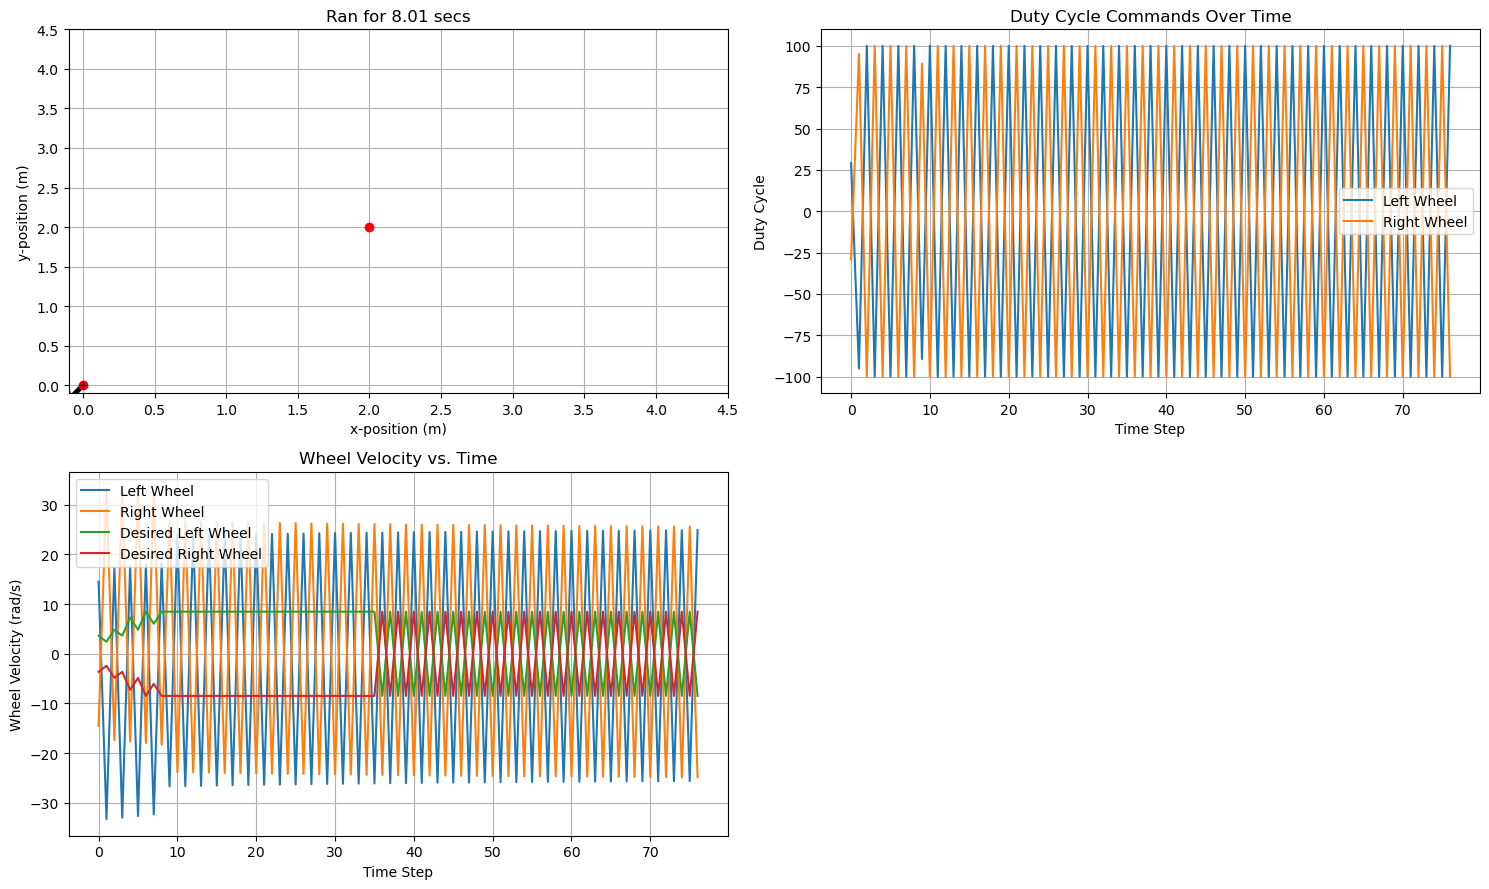

In [21]:

# Some example goal commands

# goal = (0.5, 0.5, 0)
goal = (2, 2, np.pi/2)
#goal = (0, 1, 0)
# goal = (1, 0, 0)




# Initialising controller, logging variables 
# Controller Parameters
robot = DiffDriveRobot()
controller = PIController(real_time=True) #
planner = TentaclePlanner(max_linear_velocity=0.2, max_angular_velocity=2, alpha = 1, beta = 0.1) # remember to paste in the class in the cell where I told you


robot.x = 0
robot.y = 0
robot.th = 0
robot.wl = 0
robot.wr = 0

poses = []
goal_positions = []
velocities = []
desired_velocities = []
duty_cycle_commands = []
error_sums = []
errors = []
actual_dts = []



try:
    goal_positions.append([0, 0, 0])
    goal_positions.append([goal[0],goal[1],goal[2]])

    start_time = time.time()
    while True: 
        inputs = planner.get_control_inputs(*goal, *robot.pose, strategy="tentacles")
        duty_cycle_l, duty_cycle_r, wl_desired, wr_desired = controller.drive(
                    inputs['linear_velocity'], 
                    inputs['angular_velocity'], 
                    robot.wl, 
                    robot.wr
                )
        x, y, th = robot.pose_update(duty_cycle_l, duty_cycle_r)
        display.clear_output(wait=True)

        #debugging
        print(f"Pose: x={x:.2f}, y={y:.2f}, th={th:.2f}")
        print(f"Control Inputs: v={inputs['linear_velocity']:.2f}, w={inputs['angular_velocity']:.2f}")
        print(f"Duty Cycles: left={duty_cycle_l:.2f}, right={duty_cycle_r:.2f}")
        
        
        # Log data
        # Here, I record and log everything so we can graph it.
        poses.append([x,y,th])
        duty_cycle_commands.append([duty_cycle_l,duty_cycle_r])
        velocities.append([robot.wl,robot.wr])
        desired_velocities.append([wl_desired, wr_desired])
        time.sleep(robot.dt)

except KeyboardInterrupt:
    print("Stopping robot")

    duration = time.time() - start_time

    # Plot robot data
#     display.clear_output(wait=True)
    fig = plt.figure(figsize=(15,9))
    
    plt.subplot(2, 2, 1)
    plt.plot(np.array(poses)[:,0],np.array(poses)[:,1], 'b', label='Robot Path')
    plt.plot(np.array(goal_positions)[:,0],np.array(goal_positions)[:,1],'ro', label='Goal Position')
    plt.plot(x,y,'k',marker='+')
    plt.quiver(x,y,0.1*np.cos(th),0.1*np.sin(th))
    plt.xlabel('x-position (m)')
    plt.xticks(np.arange(0, 5, 0.5))
    plt.yticks(np.arange(0, 5, 0.5))
    plt.ylabel('y-position (m)')
    plt.title(f"Ran for {duration:.2f} secs")
#     plt.axis('equal')
    plt.grid()

    plt.subplot(2, 2, 2)
    duty_cycle_commands = np.array(duty_cycle_commands)
    plt.plot(duty_cycle_commands[:, 0], label='Left Wheel')
    plt.plot(duty_cycle_commands[:, 1], label='Right Wheel')
    plt.xlabel('Time Step')
    
    plt.ylabel('Duty Cycle')
    plt.title('Duty Cycle Commands Over Time')
    plt.legend() 
    plt.grid()
    
    plt.subplot(2, 2, 3)
    velocities = np.array(velocities)
    desired_velocities = np.array(desired_velocities)
    plt.plot(velocities[:, 0], label='Left Wheel')
    plt.plot(velocities[:, 1], label='Right Wheel')
    plt.plot(desired_velocities[:, 0], label='Desired Left Wheel')
    plt.plot(desired_velocities[:, 1], label='Desired Right Wheel')
    plt.xlabel('Time Step')
    plt.ylabel('Wheel Velocity (rad/s)')
    plt.title('Wheel Velocity vs. Time')
    plt.legend() 
    plt.grid()
   
        
    fig.tight_layout()

    display.display(plt.gcf())

#     GPIO.cleanup()

    """
    Hopefully the graphs are self explanatory. If not, please ask me. I'm happy to explain anything.
    """

